# Create dataset

In [172]:
from PIL import Image
import glob
import os.path
import re

base_dir = 'c:/clustering/dataset/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
labels = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))
    labels.append(re.split("[/\\\]", filename)[-2])

print("prepared " + str(len(images)) + " images")

prepared 229 images


# Extract Features

In [173]:
X = np.ones(shape=(len(images), 0)) # initialize feature matrix X
X.shape

(229, 0)

## HSV histogram

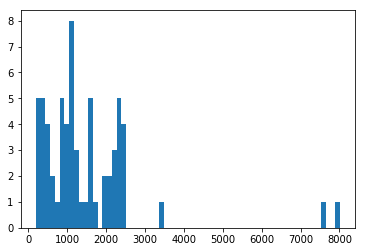

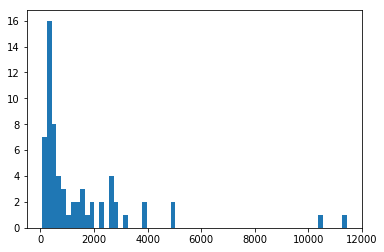

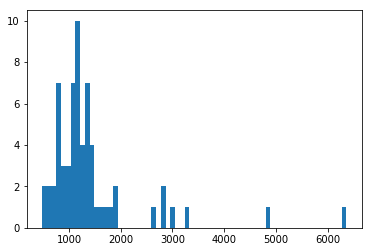

In [174]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

n_features = 64
features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

for i, image in enumerate(images):
    features[i] = np.histogram(image.convert('HSV'), bins=n_features)[0]
    if i < 3: 
        plt.hist(features[i], bins=n_features)
        plt.show()

X = np.column_stack((X, features)) # add new features to feature matrix X

## Edge histogram

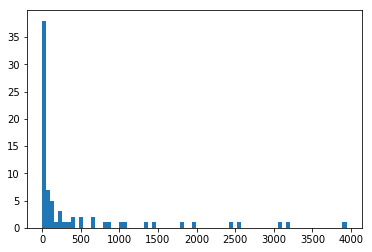

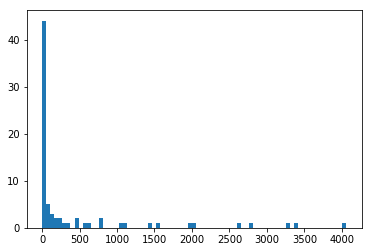

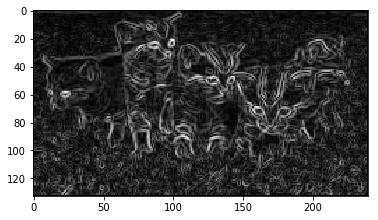

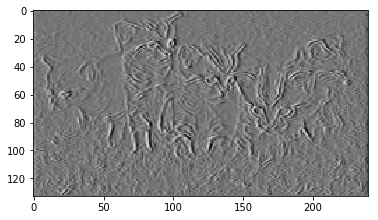

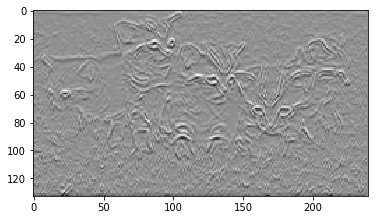

In [175]:
from skimage.filters import sobel
n_features = 75
features = np.ones(shape=(len(images), n_features*2)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    grad_y, grad_x = np.gradient(edges)
    hist_x = np.histogram(grad_x, bins=n_features)[0]
    hist_y = np.histogram(grad_y, bins=n_features)[0]
    features[i] = np.append(hist_x, hist_y)
                            
    if i < 1:
        plt.figure()
        plt.hist(hist_x, bins=n_features)
        plt.figure()
        plt.hist(hist_y, bins=n_features)
        plt.figure()
        plt.imshow(edges, cmap='gray')
        plt.figure()
        plt.imshow(grad_x, cmap='gray');
        plt.figure()
        plt.imshow(grad_y, cmap='gray');

X = np.column_stack((X, features)) # add new features to feature matrix X

# K-means clustering

In [176]:
from sklearn.cluster import KMeans
import re, shutil

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

images_by_cluster = sorted(zip(images, kmeans.labels_), key=lambda x: x[1]) # create sorted list of (<image>, <cluster>) pairs

base_dir = 'c:/clustering/result/'
shutil.rmtree(base_dir)
for image, cluster in images_by_cluster: # save images in a directory per cluster
    cluster_dir = base_dir + str(cluster)
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
    image.save(image_name, 'JPEG')


#kmeans.labels_
#kmeans.cluster_centers_


